# Model Selection + Testing

In [555]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from tqdm import tqdm
from sklearn.tree import plot_tree
from scipy.stats import norm
from scipy.stats import lognorm


### Pre-processing

In [593]:
xJuly = pd.read_csv('xJuly.csv')
xAug = pd.read_csv('xAug.csv')
xSept = pd.read_csv('xSept.csv')
xJuneEWR = pd.read_csv('xJuneEWR.csv')
xJuneIAH = pd.read_csv('xJuneIAH.csv')

yJuly = pd.read_csv('yJuly.csv')
yAug = pd.read_csv('yAug.csv')
ySept = pd.read_csv('ySept.csv')
yJuneEWR = pd.read_csv('yJuneEWR.csv')
yJuneIAH = pd.read_csv('yJuneIAH.csv')

In [594]:
#concatenates training and validation data
x = pd.concat([xJuly, xAug, xSept], ignore_index=True, axis=0)
y = pd.concat([yJuly, yAug, ySept], ignore_index=True, axis=0)

x["Target"] = y
x = x.dropna()
y = x["Target"]
x = x.iloc[:,:-1]

xJuneEWR["Target"] = yJuneEWR
xJuneEWR = xJuneEWR.dropna()
yJuneEWR = xJuneEWR["Target"]
xJuneEWR = xJuneEWR.iloc[:,:-1]

xJuneIAH["Target"] = yJuneIAH
xJuneIAH = xJuneIAH.dropna()
yJuneIAH = xJuneIAH["Target"]
xJuneIAH = xJuneIAH.iloc[:,:-1]

#filtering outliers
upperBound = 60
lowerBound = 2.5
x = x.loc[(y>lowerBound) & (y<upperBound)]
y = y.loc[(y>lowerBound) & (y<upperBound)]

xJuneEWR = xJuneEWR.loc[(yJuneEWR>0) & (yJuneEWR<upperBound)]
yJuneEWR = yJuneEWR.loc[(yJuneEWR>0) & (yJuneEWR<upperBound)]

xJuneIAH = xJuneIAH.loc[(yJuneIAH>0) & (yJuneIAH<upperBound)]
yJuneIAH = yJuneIAH.loc[(yJuneIAH>0) & (yJuneIAH<upperBound)]

### Scaling

In [595]:
xs = data_scaler(x)
xsJuneEWR = data_scaler(xJuneEWR)
xsJuneIAH = data_scaler(xJuneIAH)

#transforming y to log
yLog = np.log(y)
yEWRLog = np.log(yJuneEWR)
yIAHLog = np.log(yJuneIAH)

#train-test splits for cross-validation (80-20)
cv = KFold(n_splits=5, random_state=16, shuffle=True)


# IAH Cross Validation (July-Sept)

In [400]:
lin = LinearRegression().fit(xs, yLog)
metric_disp(lin, xs, yLog, cv)

(0.45175129366911404, 0.40250349263886137)

### Elastic Net Regression

In [401]:
#parameter tuning
l1Ratios = np.linspace(0.01,0.99,10)
alphas = np.arange(0.1, 5.1, 0.5)
escoreLog = []
for i in tqdm(l1Ratios, position=0, leave=True):
    for j in tqdm(alphas, position=0, leave=True):
        enet = ElasticNet(random_state=16, l1_ratio=i, alpha=j, max_iter=5000, tol=0.1)
        escoreLog.append(np.mean(cross_val_score(enet, xs, yLog, scoring=None, cv=cv)))

#instantiating optimal estimator
enetReg = ElasticNet(l1_ratio=l1Ratios[(np.where(escoreLog==max(escoreLog))[0][0])//10], alpha=alphas[(np.where(escoreLog==max(escoreLog))[0][0])%10])
metric_disp(enetReg, xs, yLog, cv)

100%|██████████| 10/10 [00:17<00:00,  1.71s/it]


(0.3873014247010494, 0.42550715929926597)

### K-Neigbors Regressor

In [402]:
#parameter tuning
nNeigh = np.arange(1,101,10)
scoreLog = []
for i in tqdm(nNeigh, position=0, leave=True):
    knn = KNeighborsRegressor(n_neighbors=i)
    scoreLog.append(np.mean(cross_val_score(knn, xs, yLog, scoring=None, cv=cv)))

#instantiating optimal estimator
knnReg = KNeighborsRegressor(n_neighbors=nNeigh[np.where(scoreLog==max(scoreLog))[0][0]])
metric_disp(knnReg, xs, yLog, cv)

100%|██████████| 10/10 [04:23<00:00, 26.39s/it]


(0.5359942251194425, 0.37028700254187935)

### Decision Tree Regression

In [403]:
# parameter tuning via GridSearch
dtrParams = {'max_depth':np.arange(1, 10, 1), 'min_samples_split':np.arange(2,102,20), 'max_leaf_nodes':np.arange(10,50,10)}
dtr = DecisionTreeRegressor(random_state=16)
dReg = GridSearchCV(dtr, dtrParams, refit=True)

#instantiating optimal estimator
dtrReg = dReg.fit(xs,yLog).best_estimator_
metric_disp(dtrReg, xs, yLog, cv)

(0.5838941042349415, 0.3506447317312419)

## TO-DO: FIX TREE DECISION CRITERIA (SCALED DOWN CURRENTLY)

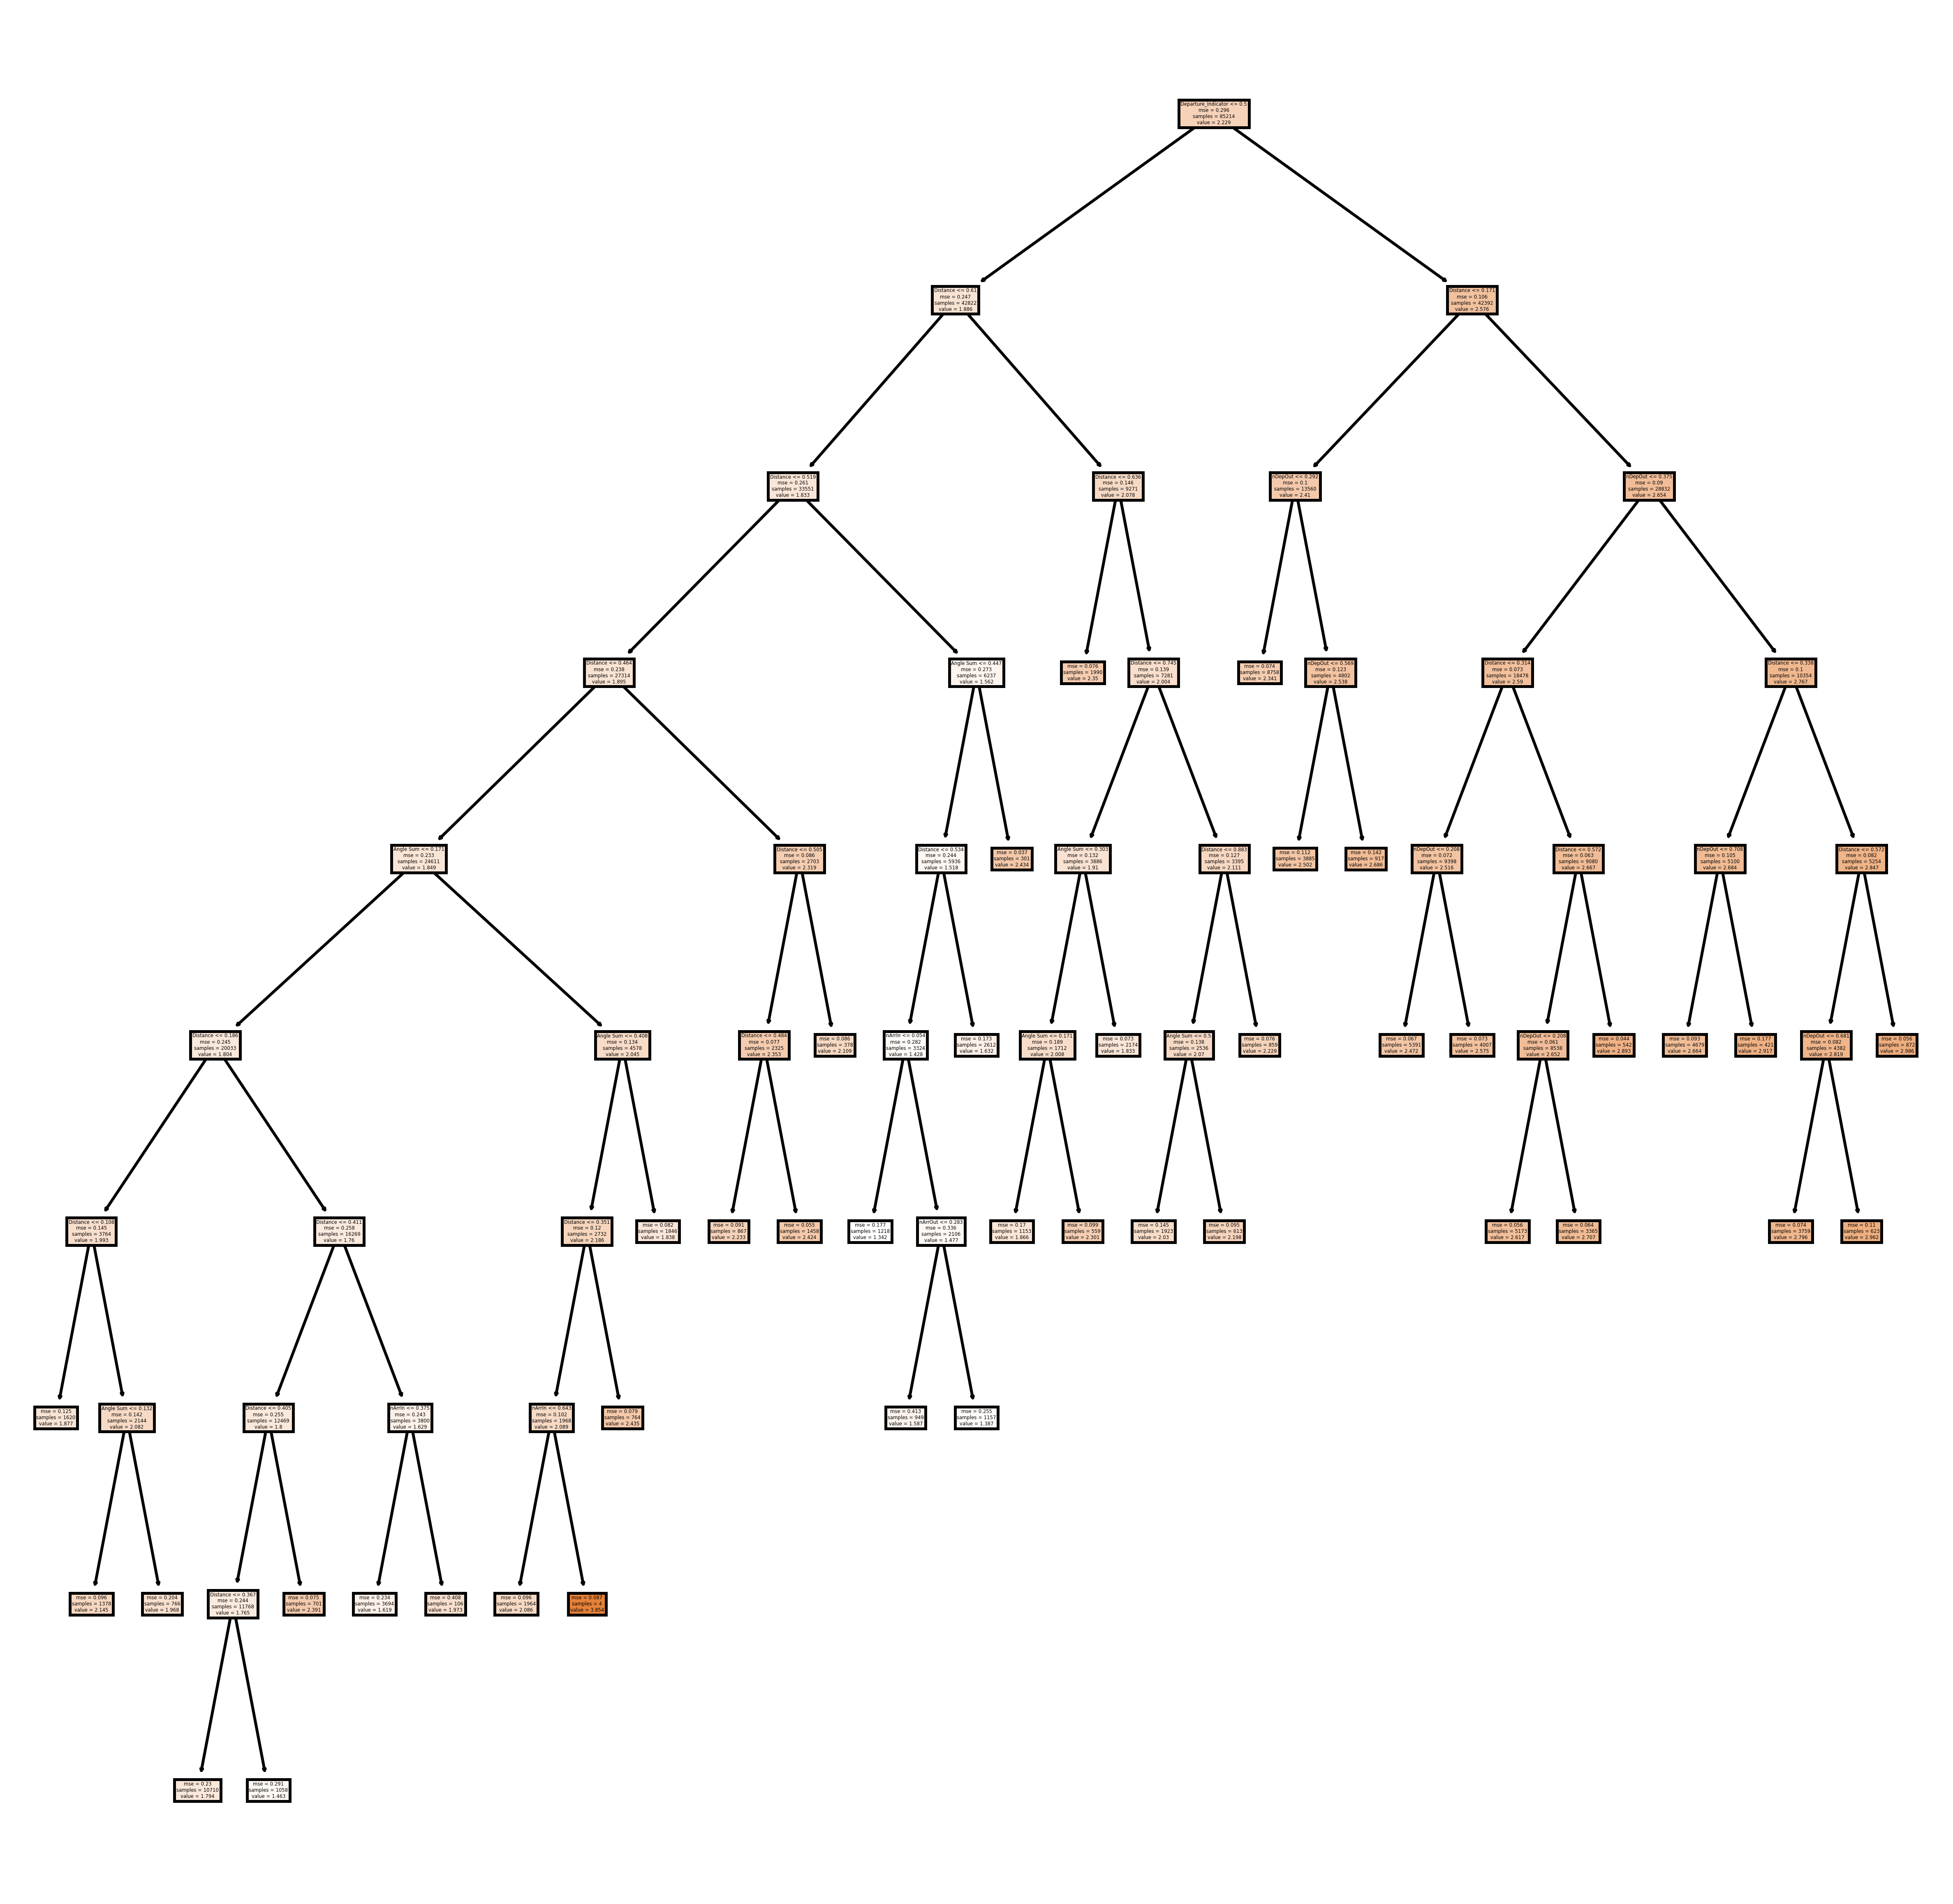

In [646]:
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (12,12), dpi=500)
plot_tree(dtrReg, feature_names = x.columns, filled = True)
fig.savefig('totaltaxidtr.png')

### Random Forest Regressor

In [405]:
rfReg = RandomForestRegressor(max_depth=10, max_leaf_nodes=102, min_samples_split=50, random_state=16)
metric_disp(rfReg, xs, yLog, cv)

(0.6094113207878717, 0.33971772452004995)

### Shallower Trees

In [406]:
# parameter tuning via GridSearch
shallowdtrParams = {'max_depth':np.arange(1, 6, 1), 'min_samples_split':np.arange(2,102,20), 'max_leaf_nodes':np.arange(10,50,10)}
shallowdtr = DecisionTreeRegressor(random_state=16)
shallowdReg = GridSearchCV(shallowdtr, shallowdtrParams, refit=True)

#instantiating optimal estimator
shallowdtrReg = shallowdReg.fit(xs,yLog).best_estimator_

#instantiating optimal estimator
shallowrfReg = RandomForestRegressor(max_depth=5, max_leaf_nodes=102, min_samples_split=50, random_state=16)

#displaying metrics
metric_disp(shallowdtrReg, xs, yLog, cv)
metric_disp(shallowrfReg, xs, yLog, cv)

(0.5461265474779875, 0.3662186419432845)

## Summary

In [407]:
models = [lin, enetReg, knnReg, dtrReg, rfReg, shallowdtrReg, shallowrfReg]
model_selection_results(models, xs, yLog, cv)

## Testing on June 2022

In [408]:
june22_results(models, xs, yLog, xsJuneEWR, yEWRLog, xsJuneIAH, yIAHLog)

# Taxi-Out Analysis

In [638]:
%run -i FAAHelpers.ipynb

In [597]:
#filter to departures only
def depFilter(dfx, dfy):
    return dfx[dfx["Departure_Indicator"]==1], dfy[dfy.index.isin(dfx[dfx["Departure_Indicator"]==1].index)]

x, y = depFilter(x, y)
xs = xs[xs["Departure_Indicator"]==1]
xJuneEWR, yJuneEWR = depFilter(xJuneEWR, yJuneEWR)
xJuneIAH, yJuneIAH = depFilter(xJuneIAH, yJuneIAH)
xsJuneEWR = xsJuneEWR[xsJuneEWR["Departure_Indicator"]==1]
xsJuneIAH = xsJuneIAH[xsJuneIAH["Departure_Indicator"]==1]

## Isolating 2Q

In [598]:
y2Log = rpt_transform("IAH", "Visual", x, y)
y2JuneEWRLog = rpt_transform("EWR", "Visual", xJuneEWR, yJuneEWR, "Departures")
y2JuneIAHLog = rpt_transform("IAH", "Visual", xJuneIAH, yJuneIAH)

### 2Q Regression

In [549]:
lin2Q = LinearRegression().fit(xs, y2Log)
lin2QR2, lin2QRMSE = metric_disp(lin2Q, xs, y2Log, cv)

#parameter tuning
l1Ratios = np.linspace(0.01,0.99,10)
alphas = np.arange(0.1, 5.1, 0.5)
escoreLog = []
for i in tqdm(l1Ratios, position=0, leave=True):
    for j in tqdm(alphas, position=0, leave=True):
        enet = ElasticNet(random_state=16, l1_ratio=i, alpha=j, max_iter=5000, tol=0.1)
        escoreLog.append(np.mean(cross_val_score(enet, xs, y2Log, scoring=None, cv=cv)))

#instantiating optimal estimator
enetReg2Q = ElasticNet(l1_ratio=l1Ratios[(np.where(escoreLog==max(escoreLog))[0][0])//10], alpha=alphas[(np.where(escoreLog==max(escoreLog))[0][0])%10])
enet2QR2, enet2QRMSE = metric_disp(enetReg2Q, xs, y2Log, cv)

#parameter tuning
nNeigh = np.arange(1,101,10)
scoreLog = []
for i in tqdm(nNeigh, position=0, leave=True):
    knn = KNeighborsRegressor(n_neighbors=i)
    scoreLog.append(np.mean(cross_val_score(knn, xs, y2Log, scoring=None, cv=cv)))

#instantiating optimal estimator
knnReg2Q = KNeighborsRegressor(n_neighbors=nNeigh[np.where(scoreLog==max(scoreLog))[0][0]])
knn2QR2, knn2QRMSE = metric_disp(knnReg2Q, xs, y2Log, cv)

# parameter tuning via GridSearch
dtrParams = {'max_depth':np.arange(1, 10, 1), 'min_samples_split':np.arange(2,102,20), 'max_leaf_nodes':np.arange(10,50,10)}
dtr = DecisionTreeRegressor(random_state=16)
dReg = GridSearchCV(dtr, dtrParams, refit=True)

#instantiating optimal estimator
dtrReg2Q = dReg.fit(xs,y2Log).best_estimator_
dtr2QR2, dtr2QRMSE = metric_disp(dtrReg2Q, xs, y2Log, cv)


rfReg2Q = RandomForestRegressor(max_depth=10, max_leaf_nodes=102, min_samples_split=50, random_state=16)
rf2QR2, rf2QRMSE = metric_disp(rfReg2Q, xs, y2Log, cv)

# parameter tuning via GridSearch
shallowdtrParams = {'max_depth':np.arange(1, 6, 1), 'min_samples_split':np.arange(2,102,20), 'max_leaf_nodes':np.arange(10,50,10)}
shallowdtr = DecisionTreeRegressor(random_state=16)
shallowdReg = GridSearchCV(shallowdtr, shallowdtrParams, refit=True)

#instantiating optimal estimator
shallowdtrReg2Q = shallowdReg.fit(xs,y2Log).best_estimator_
shallowdtr2QR2, shallowdtr2QRMSE = metric_disp(shallowdtrReg2Q, xs, y2Log, cv)

#instantiating optimal estimator
shallowrfReg2Q = RandomForestRegressor(max_depth=5, max_leaf_nodes=102, min_samples_split=50, random_state=16)
shallowrf2QR2, shallowrf2QRMSE = metric_disp(shallowrfReg2Q, xs, y2Log, cv)


100%|██████████| 10/10 [01:31<00:00,  9.18s/it]


In [553]:
models2Q = [lin2Q, enetReg2Q, knnReg2Q, dtrReg2Q, rfReg2Q, shallowdtrReg2Q, shallowrfReg2Q]
model2Q_selection_results(models2Q, xs, y2Log, cv)
june22_2Qresults(models2Q, xs, y2Log, xsJuneEWR, y2JuneEWRLog, xsJuneIAH, y2JuneIAHLog)

### Shallow Decision Tree Visualization

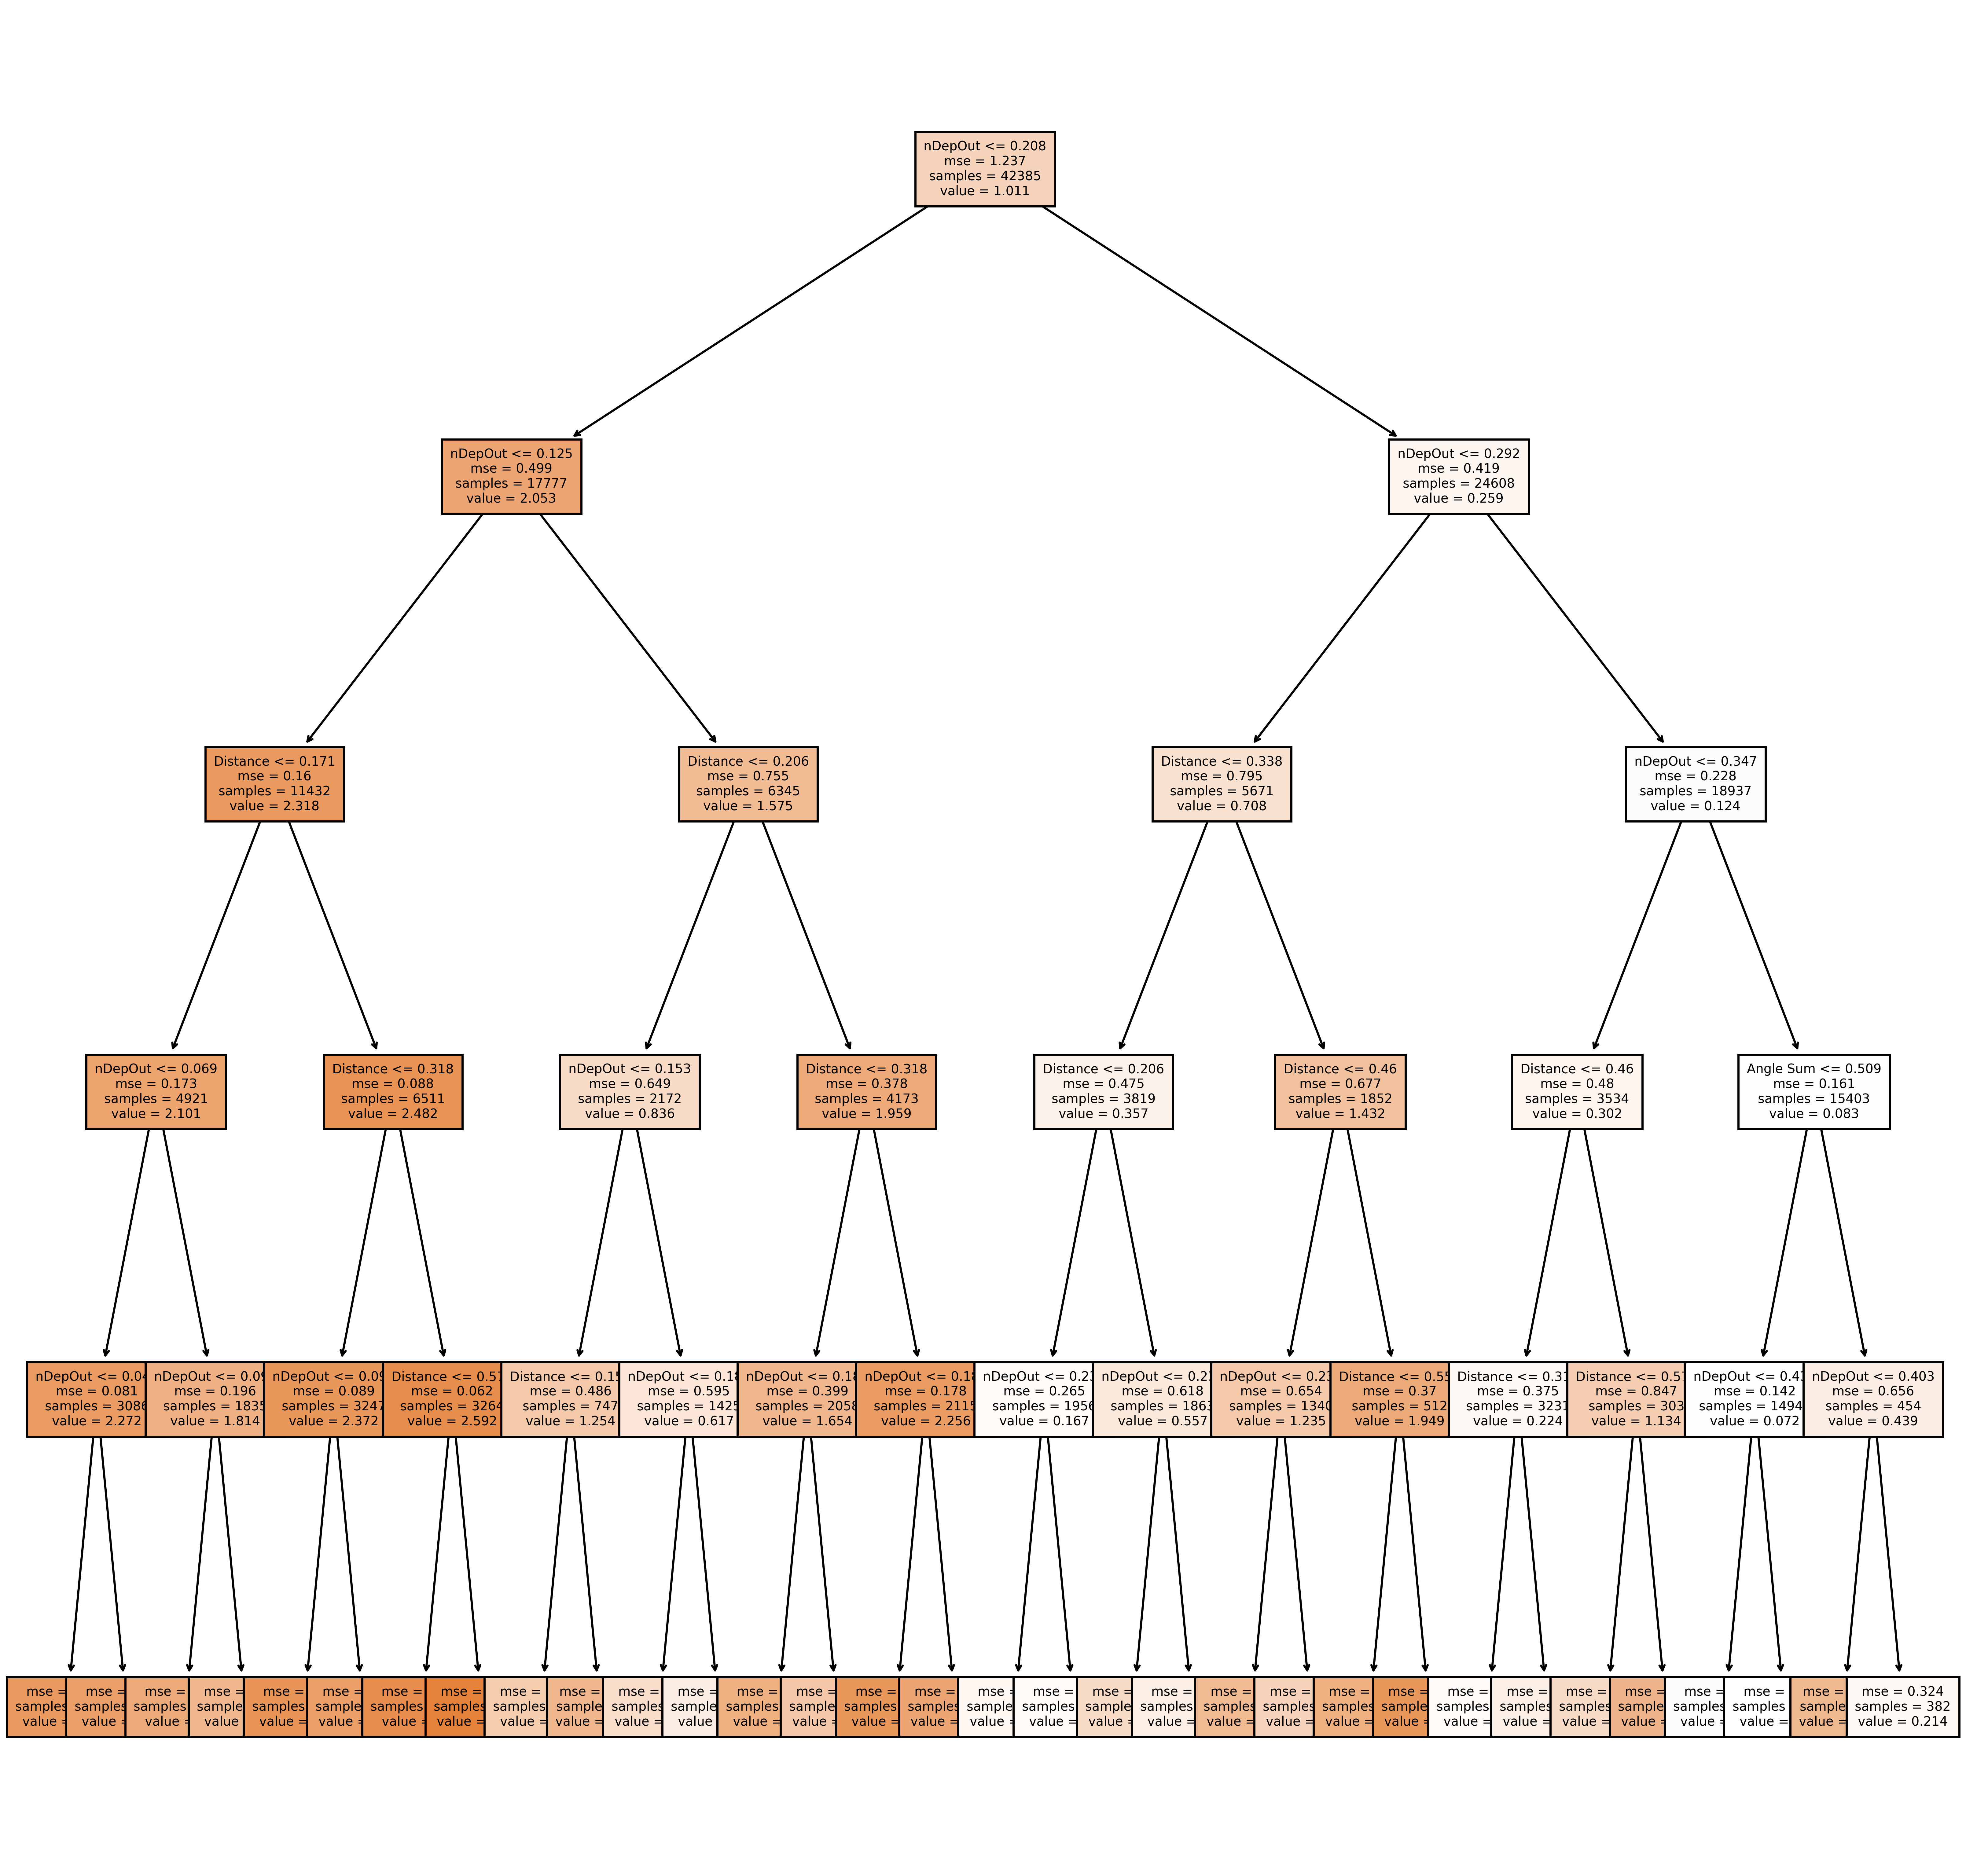

In [654]:
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (16,16), dpi=500)
plot_tree(shallowdtrReg2Q, feature_names = x.columns, filled = True, fontsize=6)
fig.savefig('2qtaxishallowdtr.png')

## Sample

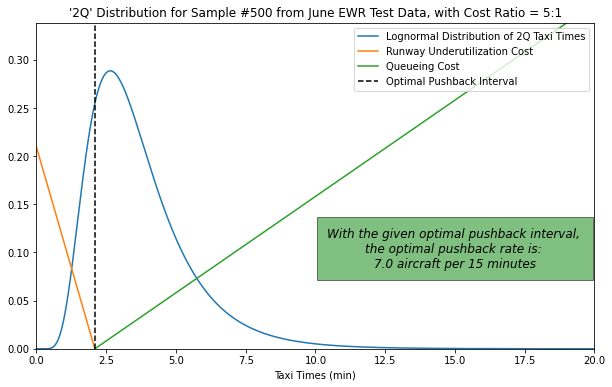

'Optimal pushback interval is 2.093 minutes.'

In [655]:
twoQ_sampler(500, xsJuneEWR, dtrReg2Q, dtr2QRMSE, 5)